# Baseline

* First we will create a baseline and iteratively improve the performance with more complex models
* Along the way we will try to fix any data related issues like data imbalance, trying different vecotorization methods etc

## Parameters to validate the final model

* Performance per class
* Latency
* Size of the model
* Inference cost
* Bias check
* Maintenance Cost

## Baseline Model

* **Randomly generated targets**
* **Simple rule based model**

### Random Model

In [1]:
import random

In [2]:
%pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 292 kB 24.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Weights and Bias to version the dataset
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 1.8 MB 21.6 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 35.1 MB/s eta 0:00:01
     |████████████████████████████████| 145 kB 30.8 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 40.4 MB/s eta 0:00:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21503 sha256=f6259f79e22eadff82b56d3fef1c4869bc1252b0a9117dc756c55d67efeb6e00
  Stored in directory: /tmp/pip-ephem-wheel-cache-lp33cd6o/wheels/54/aa/01/724885182f93150035a2a91bce34a12877e8067a97baaf5dc8
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=2f559e8db87fe07f1b052fef98f04b8f4c980d68c559c1d99b9c4e91d906eed0
  Stored in directory: /tmp/pip-ephem-wheel-cache-lp33cd6o/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built promise pathtools


In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import warnings
warnings.filterwarnings("ignore")

In [6]:
import wandb

In [7]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [8]:
import ipywidgets as widgets

In [9]:
import json

In [10]:
# Label encoder to encode class labels
class LabelEncoder(object):
    """Encode labels into unqiue ids/integers"""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        
    def __len__(self):
        return len(self.class_to_index)
    
    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"
    
    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self
    
    def encode(self, y):
        encoded = np.zeros(len(y), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded
    
    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
            
        return classes
    
    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)
    
    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [11]:
label_encoder = LabelEncoder.load("../../data_artifacts/label_encoder.json")

In [12]:
# # use this code to download the split dataset files
# import wandb
# run = wandb.init()
# artifact = run.use_artifact('alokpadhi/Medical-Transcription/Dataset_V1_0:v0', type='raw_data')
# artifact_dir = artifact.download()

In [13]:
train_df = pd.read_parquet("../../dataset/v1.0/train/train.parquet")
val_df = pd.read_parquet("../../dataset/v1.0/val/val.parquet")
test_df = pd.read_parquet("../../dataset/v1.0/test/test.parquet")

In [14]:
# validate shapes
train_df.shape, val_df.shape, test_df.shape

((3476, 2), (745, 2), (745, 2))

In [15]:
# Feature and target
X_train = train_df.transcription.to_numpy()
y_train = train_df.specialty

X_val =  val_df.transcription.to_numpy()
y_val = val_df.specialty

X_test = test_df.transcription.to_numpy()
y_test = test_df.specialty

In [16]:
# Encode all our labels
y_train = label_encoder.encode(y_train)

y_val = label_encoder.encode(y_val)

y_test = label_encoder.encode(y_test)

In [21]:
def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    np.random.seed(seed)
    random.seed(seed)

In [22]:
print(label_encoder)

<LabelEncoder(num_classes=40)>


In [23]:
print(label_encoder.classes)

['allergy / immunology', 'autopsy', 'bariatrics', 'cardiovascular / pulmonary', 'chiropractic', 'consult history phy', 'cosmetic / plastic surgery', 'dentistry', 'dermatology', 'diets nutritions', 'discharge summary', 'emergency room reports', 'endocrinology', 'ent otolaryngology', 'gastroenterology', 'general medicine', 'hematology oncology', 'hospice palliative care', 'ime qme work comp etc', 'lab medicine pathology', 'letters', 'nephrology', 'neurology', 'neurosurgery', 'obstetrics / gynecology', 'office notes', 'ophthalmology', 'orthopedic', 'pain management', 'pediatrics neonatal', 'physical medicine rehab', 'podiatry', 'psychiatry / psychology', 'radiology', 'rheumatology', 'sleep medicine', 'soap / chart / progress notes', 'speech language', 'surgery', 'urology']


In [24]:
# Let's generate  random prediction on the test set to see the performance
y_pred = np.random.randint(low=0, high=len(label_encoder), size=len(y_test))
print(y_pred.shape)
print(y_pred[:5])

(745,)
[21 27 15 30 24]


In [25]:
from sklearn.metrics import precision_recall_fscore_support

In [26]:
# Evaluate the random prediction
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recal": metrics[1], "f1": metrics[2]}
print(json.dumps(performance, indent=2))

{
  "precision": 0.0794474539311379,
  "recal": 0.03758389261744966,
  "f1": 0.04266968953802068
}


In [28]:
random_model_run = wandb.init(project="Medical-Transcription")
random_model_run.log({"precision": performance["precision"], "recall": performance["recal"], "f1-score": performance["f1"]})

### Rule Based Model

In [29]:
set_seeds()

In [38]:
from collections import Counter

In [43]:
# Let's find out most frequent 10-20 words in each class
target_word_dist = {}
for y_ in label_encoder.classes:
    filter_target_sentences = train_df.loc[train_df.specialty == y_, 'transcription'].values
    combine_words = " ".join(filter_target_sentences).split(' ')
    word_counter = Counter(combine_words).most_common(15)
    target_word_dist[y_] = [wc[0] for wc in word_counter]

In [44]:
# Check the top 15 words in each class
target_word_dist

{'allergy / immunology': ['history',
  'allergies',
  'patient',
  'noted',
  'medical',
  'allergy',
  'treatment',
  'allergic',
  'disease',
  'bilaterally',
  'asthma',
  'reaction',
  'food',
  'also',
  'masses'],
 'autopsy': ['right',
  'left',
  'inch',
  'neck',
  '1',
  'wound',
  'evidence',
  'anterior',
  'inches',
  'normal',
  'body',
  'one',
  'length',
  '2',
  'superficial'],
 'bariatrics': ['patient',
  'history',
  'also',
  'surgery',
  'weight',
  'gastric',
  'obesity',
  'pain',
  'bypass',
  'procedure',
  'pounds',
  'abdomen',
  'loss',
  'past',
  'placed'],
 'cardiovascular / pulmonary': ['left',
  'patient',
  'right',
  'artery',
  '2',
  '1',
  'coronary',
  'normal',
  'history',
  '3',
  'procedure',
  '4',
  'chest',
  '5',
  'heart'],
 'chiropractic': ['pain',
  'patient',
  'right',
  'back',
  'left',
  'dr',
  'injury',
  'work',
  'time',
  'normal',
  'lower',
  'history',
  'spine',
  'upper',
  'complaints'],
 'consult history phy': ['patient

In [54]:
import operator

In [61]:
# Match the input string words with each class word whichever gives the highest matching assign that class
def match_words(input_str):
    target_match_count = {}
    input_str_words = input_str.split(' ')
    for target_ in target_word_dist.keys():
        target_words = [wc for wc in target_word_dist[target_]]
        match_count = 0
        for word in input_str_words:
            if word in target_words:
                match_count += 1
        target_match_count[target_] = match_count
    y_pred = max(target_match_count.items(), key=operator.itemgetter(1))[0]
    return y_pred

In [72]:
y_pred = [match_words(input_str) for input_str in X_test]

In [77]:
y_pred = label_encoder.encode(y_pred)

In [78]:
y_pred.shape

(745,)

In [79]:
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recal": metrics[1], "f1": metrics[2]}
print(json.dumps(performance, indent=2))

{
  "precision": 0.3181317497805004,
  "recal": 0.24563758389261744,
  "f1": 0.245658271093684
}


As we can see above we have significantly improved our metrics than our baseline of random predictions.

In [80]:
rulebased_model_run = wandb.init(project="Medical-Transcription")
wandb.run.name = "Rule Based Model"
rulebased_model_run.log({"precision": performance["precision"], "recall": performance["recal"], "f1-score": performance["f1"]})

f1-score,▁
precision,▁
recall,▁
f1-score,0.04267
precision,0.07945
recall,0.03758


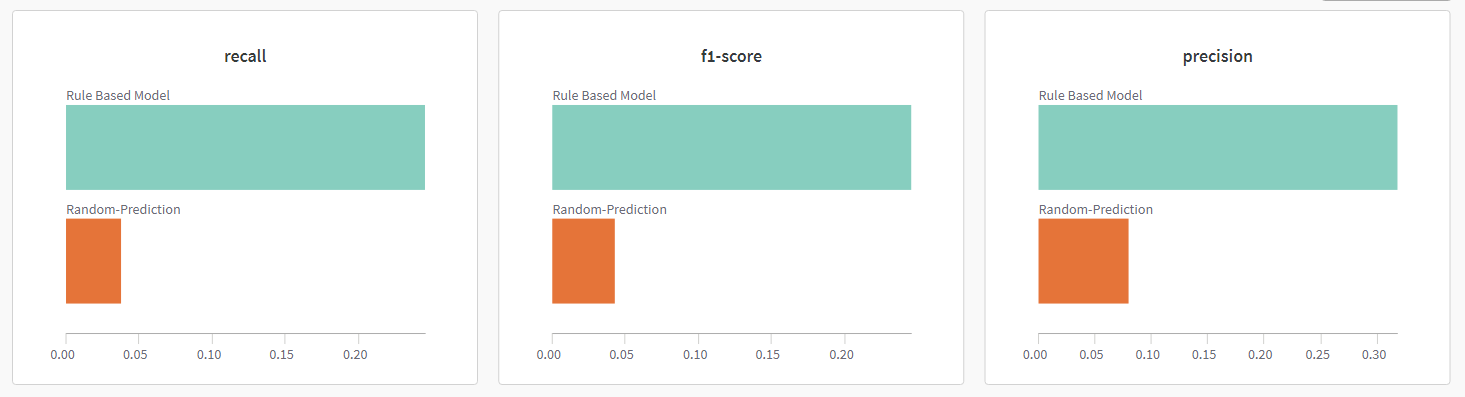